In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data import parent_labeler
from sentimentanalyser.data.text import TextList
from sentimentanalyser.utils.files import pickle_dump, pickle_load

In [3]:
from sentimentanalyser.preprocessing.processor import TokenizerProcessor
from sentimentanalyser.preprocessing.processor import NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [4]:
from functools import partial

In [5]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [6]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [7]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [8]:
imdb_data = ll_imdb.clas_databunchify(64)

In [9]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import LRFind, CudaCallback, GradientClipping
from sentimentanalyser.callbacks.training import LRFindCustom
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamScheduler, ParamSchedulerCustom
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import Recorder, RecorderCustom
from sentimentanalyser.training.trainer import Trainer

In [10]:
from sentimentanalyser.utils.dev import print_dims
from sentimentanalyser.utils.metrics import accuracy
from sentimentanalyser.utils.data import listify, compose

In [11]:
from sentimentanalyser.models.rnn import AttnAWDModel
from sentimentanalyser.models.regularization import WeightDropout

In [12]:
import torch
import torchtext
from torch import nn
from torchtext import vocab
import matplotlib.pyplot as plt

In [13]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [14]:
glove_eng = vocab.GloVe(cache=path_cache)

In [15]:
local_vocab = proc_num.vocab

## Custom Optimizer

In [16]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
    
    def grad_params(self):
        return [(p, hyper) for pg,hyper in zip(self.param_groups, self.hypers)
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def step(self):
        for p,hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

### Basic SGD

In [17]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

### Weight Decay

In [18]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [19]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

## add defaults

In [20]:
def maybe_update(objs, dest, f):
    for obj in objs:
        for k,v in f(obj).items():
            if k not in dest:
                dest[k] = v

In [21]:
def get_defaults(d):
    return getattr(d, '_defaults', {})

In [22]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        
        self.param_groups = list(params)
        
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        
        self.hypers = [{**defaults} for p in self.param_groups]
    
    def grad_params(self):
        return [(p, hyper) for pg,hyper in zip(self.param_groups, self.hypers)
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def step(self):
        for p,hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

# Stateful Optimizer

In [23]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        # geting hyperparameter default values from Stat objects.
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        # It's going to be a dictionary of dictionaries. One dict for each parameter with contains the state info based on what stats need to be stored.
        self.state = {}
    
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                # When running for the first time.
                # Create a state for p and call all the statistics to initalize it.
                self.state[p] = {}
                # Take the default value of states from the init_state function in the stat object.
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            # Take the previous state.
            state = self.state[p]
            for stat in self.stats:
                # update it.
                state = stat.update(p, state, **hyper)
            # Run steppers this time aslo pass the state as well.
            compose(p, self.steppers, **state, **hyper)
            # set the new state as prev for next iteration.
            self.state[p] = state

In [24]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
    
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o:o.init_state(p))
            state = self.state[p]
            for stat in self.stats:
                stat = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [25]:
class Stat():
    _defaults = {}
    def init_state(self, p):
        raise NotImplementedError
    
    def update(self, p, state, **kwargs):
        raise NotImplementedError

In [26]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False):
        self.dampening = dampening
    
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'],p.grad.data)
        return state

In [27]:
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True):
        self.dampening = dampening
    
    def init_state(self, p):
        return {'sqr_avg':torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [28]:
torch.addcmul??

In [29]:
class StepCount(Stat):
    def init_state(self, p):
        return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [30]:
def debias(mom, damp, step):
    return damp * (1 - mom**step) / (1 - mom)

In [31]:
torch.addcdiv??

In [32]:
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    
    p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

### Momentum

In [33]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

## Optimizers

In [34]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [35]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                      stats=AverageGrad(), wd=0.01)

In [36]:
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step, weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

# Training

In [37]:
def get_basic(Model, num_layers=2):
    model = Model(proc_num.vocab, glove_eng,num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    opt = adam_opt()(model.parameters())
    return model, loss_func, opt

In [38]:
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [39]:
print(create_phases(0.5))

[0.5, 0.5]


In [40]:
finder = Trainer(imdb_data,*get_basic(AttnAWDModel),cb_funcs=[LRFindCustom,
                                                              RecorderCustom,
                                                              ProgressCallback,
                                                              CudaCallback])

In [41]:
finder.fit()

/home/anukoolpurohit/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  if sys.path[0] == '':


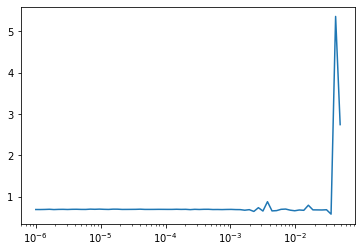

In [42]:
finder.recorder_custom.plot(skip_last=20)

In [43]:
lr = 3e-3
pct_start = 0.5
phases = create_phases(pct_start)

In [44]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [45]:
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [46]:
cbfs = [partial(AvgStatsCallback, [accuracy]),
        partial(ParamSchedulerCustom,'lr', [sched_lr]),
        partial(ParamSchedulerCustom, 'mom', [sched_mom]),
        partial(GradientClipping, clip=0.1),
        ProgressCallback,
        CudaCallback,
        RecorderCustom
       ]

In [47]:
trainer = Trainer(imdb_data, *get_basic(AttnAWDModel), cb_funcs=cbfs)

In [48]:
trainer.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.439961,0.792240,0.282770,0.886560,01:35
1,0.301579,0.876240,0.229877,0.909160,01:37
2,0.217544,0.917120,0.226080,0.912200,01:37
3,0.147254,0.946760,0.207823,0.925760,01:38


/home/anukoolpurohit/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/utils/clip_grad.py:24: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  parameters = list(filter(lambda p: p.grad is not None, parameters))


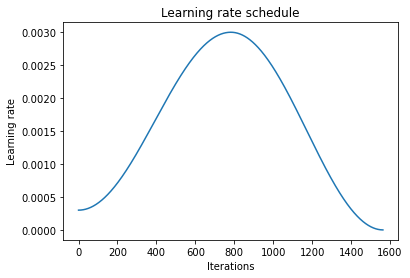

In [49]:
trainer.recorder_custom.plot_lr()

In [50]:
len(trainer.opt.param_groups), trainer.opt.hypers

(1,
 [{'mom': 0.9499995965255831,
   'sqr_mom': 0.99,
   'eps': 1e-05,
   'wd': 0.0,
   'lr': 4.2104111465119526e-08}])